# Neutron reflectometry analysis of lipid monolayers with lipid bilayer reservoirs separated by a highly solvated gap

This notebook allows the co-refinement of multiple contrasts of lipid monolayers presenting lipid reservoirs separated by a hihgly solvated gap

 - A model of 6 layers is used: tails | heads | gap | heads | tails | heads
 - The possibility to include a guest molecule in heads and/or tails, a protein in this case, is implemented 
 - A constraint to make sure [surface excess of heads = surface excess of tails] in the monolayer is applied
 - Constraint to make sure [2 * surface excess of heads = surface excess of tails] in the reservoir is applied
 - The thickness of the headgroup layers in the monolayers and the reservoir is fitted to a common value
 - The tails SLD is fitted to account tail compaction and/or loss of molecules into the bulk

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path
import glob


import refnx, scipy

# the analysis module contains the curvefitting engine
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective, process_chain, Interval, Transform

# the reflect module contains functionality relevant to reflectometry
from refnx.reflect import SLD, ReflectModel, Structure, LipidLeaflet, Slab, create_occupancy

# the ReflectDataset object will contain the data
from refnx.dataset import ReflectDataset

# version numbers used in this analysis
refnx.version.version, scipy.version.version

('0.1.52', '1.14.1')

#### Loading the data

In [2]:
pth = os.getcwd()

data_dLip_acmw = ReflectDataset(os.path.join(pth, 'dLips_10SPB_ACMW_45.mft'))
data_dLip_acmw.name = "dLip_acmw"

data_dLip_d2o = ReflectDataset(os.path.join(pth, 'dLips_10SPB_D2O_45.mft'))
data_dLip_d2o.name = "dLip_d2o"

# data_hLip_acmw = ReflectDataset(os.path.join(pth, 'hLips_10SPB_ACMW_45.mft'))
# data_hLip_acmw.name = "hLip_acmw"

data_hLip_d2o = ReflectDataset(os.path.join(pth, 'hLips_10SPB_D2O_45.mft'))
data_hLip_d2o.name = "hLip_d2o"


### Define all the necessary parameters to create the `structure` for each contrast:
Scattering lengths, molecular volume, SLD, roughness, thickness, volume fraction of solvent

In [ ]:
air = SLD(0 + 0j, 'air')

# The following represent the solvent contrasts used in the experiment
d2o_hlip = SLD(6.15 + 0j, 'd2o_hlip')
d2o_dlip = SLD(6.15 + 0j, 'd2o_dlip')
acmw = SLD(0 + 0j, 'acmw')

# Define molecular volumes
vm_tail = 871.37
vm_head = 330.96
vm_p = 1120
vm_lip = vm_tail + vm_head
vm_tail_reservoir = 871.37


# Define scattering length (SL) of tails, heads, lipid molecule and proteins
dtail_SL = 428.46 
htail_SL = -13.6

d_head_d2o_SL = 90.44
d_head_acmw_SL = 79.31
h_head_d2o_SL = 88.91
h_head_acmw_SL = 78.34

d_lip_d2o_SL = dtail_SL + d_head_d2o_SL
d_lip_acmw_SL = dtail_SL + d_head_acmw_SL
h_lip_d2o_SL = htail_SL + h_head_d2o_SL
h_lip_acmw_SL = htail_SL + h_head_acmw_SL

spb_acmw_SLD = 1.598
spb_d2o_SLD = 2.591

#Define scattering length density (SLD) of the lipid molecules

d_lip_d2o_SLD = 10*d_lip_d2o_SL/vm_lip
d_lip_acmw_SLD = 10*d_lip_acmw_SL/vm_lip
h_lip_d2o_SLD = 10*h_lip_d2o_SL/vm_lip
h_lip_acmw_SLD = 10*h_lip_acmw_SL/vm_lip


# Monolayer / tails layer
rough_monolayer = Parameter(value=4.5, name='rough_monolayer', vary=False, bounds=Interval(lb=4, ub=8))
tail_thick = Parameter(value=19.5, name='tail_thick', vary=True, bounds=Interval(lb=10, ub=30))
htail_SLD = Parameter(value=-0.5, name='htail_SLD', vary=True, bounds=Interval(lb=10*htail_SL/vm_tail, ub=1.5*10*htail_SL/vm_tail))
dtail_SLD = Parameter(value=4.5, name='dtail_SLD', vary=True, bounds=Interval(lb=10*dtail_SL/vm_tail, ub=1.5*10*dtail_SL/vm_tail))
tail_vfsolv = Parameter(value=0.0, name='tail_vfsolv')


# Monolayer / headgroups layer
head_thick = Parameter(value=10, name='head_thick', vary=True, bounds=Interval(lb=8, ub=15))
d_head_d2o_SLD = Parameter(value=10*d_head_d2o_SL/vm_head, name='d_head_d2o_SLD')
d_head_acmw_SLD = Parameter(value=10*d_head_acmw_SL/vm_head, name='d_head_acmw_SLD')
h_head_d2o_SLD = Parameter(value=10*h_head_d2o_SL/vm_head, name='h_head_d2o_SLD')
# h_head_acmw_SLD = Parameter(value=10*h_head_acmw_SL/vm_head, name='h_head_acmw_SLD')
head_vfsolv = Parameter(value=0.35, name='head_vfsolv', vary=True, bounds=Interval(lb=0, ub=0.7))

# Gap layer Solvent layer between monolayer and reservoirs
# This layer must be included to fit the data. The SPB protein stablizes the formation of resersvoirs bridging the interfacial monolayer with
# subsurface structrues
gap_thick = Parameter(value=25, name='gap_thick', vary=True, bounds=Interval(lb=10, ub=50))
gap_vfsolv_dlip_acmw = Parameter(value=1, name='gap_vfsolv_dlip_acmw', vary=True, bounds=Interval(lb=0, ub=1))
gap_vfsolv_dlip_d2o = Parameter(value=1, name='gap_vfsolv_dlip_d2o', vary=True, bounds=Interval(lb=0, ub=1))
gap_vfsolv_hlip_d2o = Parameter(value=1, name='gap_vfsolv_hlip_d2o', vary=True, bounds=Interval(lb=0, ub=1))
# gap_vfsolv_hlip_acmw = Parameter(value=0.95, name='gap_vfsolv_dlip_acmw', vary=True, bounds=Interval(lb=0, ub=1))
rough_reservoir = Parameter(value=4.5, name='rough_reservoir', vary=False, bounds=Interval(lb=4, ub=8))

#Reservoir layer divided in headgroups/tails/headgroups
# The thickness of the headgroups is a parameter shared with the monolayer
headreservoir_vfsolv_dlip_acmw = Parameter(value=0.97, name='headreservoir_vfsolv_dlip_acmw', vary=True, bounds=Interval(lb=0.5, ub=0.99))
headreservoir_vfsolv_dlip_d2o = Parameter(value=0.97, name='headreservoir_vfsolv_dlip_d2o', vary=True, bounds=Interval(lb=0.5, ub=0.99))
headreservoir_vfsolv_hlip_d2o = Parameter(value=0.97, name='headreservoir_vfsolv_hlip_d2o', vary=True, bounds=Interval(lb=0.5, ub=0.99))
# headreservoir_vfsolv_hlip_acmw = Parameter(value=0.95, name='headreservoir_vfsolv', vary=True, bounds=Interval(lb=0.5, ub=0.99))

tailreservoir_thick = Parameter(value=25, name='tailreservoir_thick', vary=True, bounds=Interval(lb=20, ub=40))
tailreservoir_vfsolv_dlip_acmw = Parameter(value=0.95, name='tailreservoir_vfsolv_dlip_acmw', vary=True, bounds=Interval(lb=0.2, ub=0.99))
tailreservoir_vfsolv_dlip_d2o = Parameter(value=0.95, name='tailreservoir_vfsolv_dlip_d2o', vary=True, bounds=Interval(lb=0.2, ub=0.99))
tailreservoir_vfsolv_hlip_d2o = Parameter(value=0.95, name='tailreservoir_vfsolv_dlip_d2o', vary=True, bounds=Interval(lb=0.2, ub=0.99))
# tailreservoir_vfsolv_hlip_acmw = Parameter(value=0.95, name='tailreservoir_vfsolv_dlip_d2o', vary=True, bounds=Interval(lb=0.2, ub=0.99))
# It is necessary to define the SLD of the tails in the reservoir, as the SLD in the monolayer is varied iteratively during fitting to account for acyl chain compaction and/or lipid loss to the bulk
htail_SLD_reservoir = Parameter(value=10*htail_SL/vm_tail_reservoir, name='htail_SLD_reservoir', vary=False)
dtail_SLD_reservoir = Parameter(value=10*dtail_SL/vm_tail_reservoir, name='dtail_SLD_reservoir', vary=False)

# Based on the previously defined parameters, the slabs for the different contrasts are constructed
htail_d2o = Slab(tail_thick, htail_SLD, rough_monolayer, 'tail', tail_vfsolv)
# htail_acmw = Slab(tail_thick, htail_SLD, rough_monolayer, 'tail', tail_vfsolv)
dtail_d2o = Slab(tail_thick, dtail_SLD, rough_monolayer, 'dtail', tail_vfsolv)
dtail_acmw = Slab(tail_thick, dtail_SLD, rough_monolayer, 'dtail', tail_vfsolv)

d_head_d2o = Slab(head_thick, d_head_d2o_SLD, rough_monolayer, 'head', head_vfsolv)
d_head_acmw = Slab(head_thick, d_head_acmw_SLD, rough_monolayer, 'head', head_vfsolv)
h_head_d2o = Slab(head_thick, h_head_d2o_SLD, rough_monolayer, 'head', head_vfsolv)
# h_head_acmw = Slab(head_thick, h_head_acmw_SLD, rough_monolayer, 'head', head_vfsolv)

gap_d_acmw = Slab(gap_thick, spb_acmw_SLD, rough_reservoir, 'gap_d_acmw', gap_vfsolv_dlip_acmw)
gap_d_d2o = Slab(gap_thick, spb_d2o_SLD, rough_reservoir, 'gap_d_d2o', gap_vfsolv_dlip_d2o)
gap_h_d2o = Slab(gap_thick, spb_d2o_SLD, rough_reservoir, 'gap_h_d2o', gap_vfsolv_hlip_d2o)
# gap_h_acmw = Slab(gap_thick, spb_acmw_SLD, rough_reservoir, 'gap_h_acmw', gap_vfsolv_hlip_acmw)

d_headreservoir_lip_d2o= Slab(head_thick, d_head_d2o_SLD, rough_reservoir, 'headreservoir', headreservoir_vfsolv_dlip_d2o)
d_headreservoir_lip_acmw= Slab(head_thick, d_head_acmw_SLD, rough_reservoir, 'headreservoir', headreservoir_vfsolv_dlip_acmw)
h_headreservoir_lip_d2o= Slab(head_thick, h_head_d2o_SLD, rough_reservoir, 'headreservoir', headreservoir_vfsolv_hlip_d2o)
# h_headreservoir_lip_acmw= Slab(head_thick, h_head_acmw_SLD, rough_reservoir, 'headreservoir', headreservoir_vfsolv_hlip_acmw)
tailreservoir_dlip_acmw = Slab(tailreservoir_thick, dtail_SLD_reservoir, rough_reservoir, 'tailreservoir', tailreservoir_vfsolv_dlip_acmw)
tailreservoir_dlip_d2o = Slab(tailreservoir_thick, dtail_SLD_reservoir, rough_reservoir, 'tailreservoir', tailreservoir_vfsolv_dlip_d2o)
tailreservoir_hlip_d2o = Slab(tailreservoir_thick, htail_SLD_reservoir, rough_reservoir, 'tailreservoir', tailreservoir_vfsolv_hlip_d2o)
# tailreservoir_hlip_acmw = Slab(tailreservoir_thick, htail_SLD_reservoir, rough_reservoir, 'tailreservoir', tailreservoir_vfsolv_hlip_acmw)

# The following parameters define the volume fraction of the protein in heads (p_heads_vf) and tails (p_tails_vf)
p_heads_vf = Parameter(value=0.009494, name='p_head_vfsolv', vary=False, bounds=Interval(lb=0.0, ub=1.0))
p_tails_vf = Parameter(value=0.009494, name='p_tails_vfsolv', vary=False, bounds=Interval(lb=0.0, ub=1.0))

# The surface excess and area per molecule of heads and tails in the monolayer and reservoirs is calculated
Gamma_tails_monolayer = (tail_thick*dtail_SLD*(1 - p_tails_vf))/(dtail_SL*0.06023)
Gamma_heads_monolayer = (head_thick*d_head_acmw_SLD*(1 - p_heads_vf - head_vfsolv))/(d_head_acmw_SL*0.06023)
A_permolecule_tails_monolayer = 10**20/(Gamma_tails_monolayer*10**-6*6.022*10**23)
A_permolecule_heads_monolayer =10**20/(Gamma_heads_monolayer*10**-6*6.022*10**23)

# The surface excess of tails and heads in the reservoirs is calculated
Gamma_heads_reservoir_dlip_acmw = (head_thick*d_head_acmw_SLD*(1 - headreservoir_vfsolv_dlip_acmw))/(d_head_acmw_SL*0.06023)
Gamma_tails_reservoir_dlip_acmw = (tailreservoir_thick*dtail_SLD_reservoir*(1 - tailreservoir_vfsolv_dlip_acmw))/(dtail_SL*0.06023)
Gamma_heads_reservoir_dlip_d2o = (head_thick*d_head_d2o_SLD*(1 - headreservoir_vfsolv_dlip_d2o))/(d_head_d2o_SL*0.06023)
Gamma_tails_reservoir_dlip_d2o = (tailreservoir_thick*dtail_SLD_reservoir*(1 - tailreservoir_vfsolv_dlip_d2o))/(dtail_SL*0.06023)
Gamma_heads_reservoir_hlip_d2o = (head_thick*h_head_d2o_SLD*(1 - headreservoir_vfsolv_hlip_d2o))/(h_head_d2o_SL*0.06023)
Gamma_tails_reservoir_hlip_d2o = (tailreservoir_thick*htail_SLD_reservoir*(1 - tailreservoir_vfsolv_hlip_d2o))/(dtail_SL*0.06023)

#### Define the constraints to be applied in the fit

In [4]:
# (1) The first constraint is ensuring that the surface excess of tails and heads in the monolayer is the same
# The calculation is taking the account the amount of protein in heads and/or tails that must be defined previously as p_heads_vf and/or p_tails_vf

head_vfsolv.set_constraint(1 - p_heads_vf - ((tail_thick * ((d_head_acmw_SL * 0.06023 * dtail_SLD * (1 - p_tails_vf))))/(d_head_acmw_SLD * head_thick * 0.06023 * dtail_SL)))

def calculate_heads_vf():
    return 1 - head_vfsolv.value - p_heads_vf.value

heads_vf = Parameter(name='heads_vf')
heads_vf.set_constraint(calculate_heads_vf)

# (2) A second constraint is applied to ensure that the SLDs of the deuterated and hydrogenous tails vary in a consistent manner during fitting
# htail_SLD = 10*htail_SL/vm_tail;  dtail_SLD = 10*dtail_SL/vm_tail --> vm_tail = 10*dtail_SL/dtail_SLD --> htail_SLD = 10*htail_SL/(10*dtail_SL/dtail_SLD)

htail_SLD.set_constraint(
    10*htail_SL/(10*dtail_SL/dtail_SLD))

# (3) The third constraint applied to tailreservoir_vfsolv ensures that the surface excess of tails and headgroups in the reservoirs is the same
# Note that, since there are two layers of headgroups but only one layer of tails, the surface excess of the tails must be twice that of the headgroups

tailreservoir_vfsolv_dlip_acmw.set_constraint(
    1- (2*head_thick * d_head_acmw_SLD * (1 - headreservoir_vfsolv_dlip_acmw) * dtail_SL) / (tailreservoir_thick* dtail_SLD_reservoir * d_head_acmw_SL))

tailreservoir_vfsolv_dlip_d2o.set_constraint(
    1- (2*head_thick * d_head_d2o_SLD * (1 - headreservoir_vfsolv_dlip_d2o) * dtail_SL) / (tailreservoir_thick* dtail_SLD_reservoir * d_head_d2o_SL))

tailreservoir_vfsolv_hlip_d2o.set_constraint(
    1- (2*head_thick * d_head_d2o_SLD * (1 - headreservoir_vfsolv_hlip_d2o) * dtail_SL) / (tailreservoir_thick* dtail_SLD_reservoir * d_head_d2o_SL))

#### Define the `structure` of the different contrasts

In [5]:
dLip_acmw = air | dtail_acmw | d_head_acmw | gap_d_acmw | d_headreservoir_lip_acmw | tailreservoir_dlip_acmw | d_headreservoir_lip_acmw | acmw(0, rough_reservoir)
dLip_d2o = air | dtail_d2o | d_head_d2o | gap_d_d2o | d_headreservoir_lip_d2o |tailreservoir_dlip_d2o | d_headreservoir_lip_d2o | d2o_dlip(0, rough_reservoir)
# hLip_acmw = air | htail_acmw | h_head_acmw | gap_h_acmw | h_headreservoir_lip_acmw | tailreservoir_hlip_acmw | h_headreservoir_lip_acmw |acmw(0, rough_reservoir)
hLip_d2o = air | htail_d2o | h_head_d2o | gap_h_d2o | h_headreservoir_lip_d2o | tailreservoir_hlip_d2o | h_headreservoir_lip_d2o | d2o_hlip(0, rough_reservoir)

#### Create a `model` for each dataset based on the `structure` previously defined

In [6]:
scale = 1.0
bkg = 1e-6
name = 'model'
dq = 7

model_dLip_acmw = ReflectModel(dLip_acmw, scale, bkg, 'model_dLip_acmw', dq)
model_dLip_d2o = ReflectModel(dLip_d2o, 0.986, bkg, 'model_dLip_d2o', dq)
# model_hLip_acmw = ReflectModel(hLip_acmw, scale, bkg, 'model_hLip_acmw', dq)
model_hLip_d2o = ReflectModel(hLip_d2o, 0.964, 1e-07, 'model_hLip_d2o', dq)

#### Combine model and data into a `objective` for each contrast

In [7]:
YX4 = Transform('YX4')

objective_dLip_acmw = Objective(model_dLip_acmw, data_dLip_acmw, transform=YX4, name='dLip_acmw')
objective_dLip_d2o = Objective(model_dLip_d2o, data_dLip_d2o, transform=YX4, name='dLip_d2o')
# objective_hLip_acmw = Objective(model_hLip_acmw, data_hLip_acmw, transform=YX4, name='hLip_acmw')
objective_hLip_d2o = Objective(model_hLip_d2o, data_hLip_d2o, transform=YX4, name='hLip_d2o')


#### Combine multiple objectives into a `global objective` to corefine different contrasts

In [8]:
objective_dLip_acmw.weighted = objective_dLip_d2o.weighted = objective_hLip_d2o.weighted = True 
global_objective = GlobalObjective([objective_dLip_acmw, objective_dLip_d2o, objective_hLip_d2o])

#### Create and perform fitting routine

In [9]:
fitter = CurveFitter(global_objective)
fitter.fit('differential_evolution', popsize=10)

-6010.702648711399: : 68it [00:46,  1.47it/s] 


             message: Optimization terminated successfully.
             success: True
                 fun: -6065.13071082804
                   x: [ 1.599e+01  5.394e+00  1.159e+01  2.338e+01
                        1.000e+00  9.715e-01  2.394e+01  9.975e-01
                        9.171e-01  9.917e-01  9.838e-01]
                 nit: 68
                nfev: 9414
          population: [[ 1.571e+01  5.454e+00 ...  9.852e-01  9.841e-01]
                       [ 1.628e+01  5.295e+00 ...  9.941e-01  9.762e-01]
                       ...
                       [ 1.542e+01  5.544e+00 ...  9.807e-01  9.807e-01]
                       [ 1.586e+01  5.414e+00 ...  9.905e-01  9.847e-01]]
 population_energies: [-6.065e+03 -5.766e+03 ... -5.916e+03 -5.943e+03]
                 jac: [-1.275e-01 -3.642e-01  1.191e-02 -6.231e-01
                       -9.129e+02  1.766e+00  9.252e-01  2.712e-01
                       -1.365e+00 -2.865e-02  2.775e-01]
               covar: [[ 8.407e-03 -1.835e-03 .

#### Print chi2 and a summary of the fitted paremeters

In [10]:
print(f"chi2: {global_objective.chisqr()/(global_objective.npoints - len(global_objective.varying_parameters()))}")
print(global_objective.parameters.varying_parameters())

chi2: 4.280564136927514
________________________________________________________________________________
Parameters:      None      
<Parameter: 'tail_thick'  , value=15.987 +/- 0.0917, bounds=[10.0, 30.0]>
<Parameter:  'dtail_SLD'  , value=5.39432 +/- 0.0208, bounds=[4.917084590931521, 7.375626886397282]>
<Parameter: 'head_thick'  , value=11.5948 +/- 0.306, bounds=[8.0, 15.0]>
<Parameter:  'gap_thick'  , value=23.3832 +/- 1.24 , bounds=[10.0, 50.0]>
<Parameter:'gap_vfsolv_dlip_acmw', value=1 +/- 0.00951, bounds=[0.0, 1.0]>
<Parameter:'headreservoir_vfsolv', value=0.971461 +/- 0.000694, bounds=[0.5, 0.99]>
<Parameter:'tailreservoir_thick', value=23.9381 +/- 0.889, bounds=[20.0, 40.0]>
<Parameter:'gap_vfsolv_dlip_d2o', value=0.997483 +/- 0.00575, bounds=[0.0, 1.0]>
<Parameter:'headreservoir_vfsolv_dlip_d2o', value=0.917112 +/- 0.00232, bounds=[0.5, 0.99]>
<Parameter:'gap_vfsolv_hlip_d2o', value=0.991701 +/- 0.00434, bounds=[0.0, 1.0]>
<Parameter:'headreservoir_vfsolv_dlip_d2o', value=0.

##### Print summary of the most relevant parameters

In [11]:
print(f"chi2: {global_objective.chisqr()/(global_objective.npoints - len(global_objective.varying_parameters()))}")
print("MONOLAYER")
print(tail_thick)
print(p_tails_vf)
print(dtail_SLD)
print(htail_SLD)
print(f"Delta %SLD: {100*(dtail_SLD.value-4.92)/4.92}")
print()
print(head_thick)
print(head_vfsolv)
print(p_heads_vf)
print(rough_monolayer)
print()
print(f"Gamma_tails_monolayer: {Gamma_tails_monolayer}")
print(f"Gamma_heads_monolayer: {Gamma_heads_monolayer}")
print(f"A_permolecule_tails_monolayer: {A_permolecule_tails_monolayer}")
print(f"A_permolecule_heads_monolayer: {A_permolecule_heads_monolayer}")
print()
print("GAP LAYER")
print(gap_thick)
print(gap_vfsolv_dlip_acmw)
print(gap_vfsolv_dlip_d2o)
print(gap_vfsolv_hlip_d2o)
print()
print("RESERVOIR LAYER")
print(head_thick)
print(headreservoir_vfsolv_dlip_acmw)
print(headreservoir_vfsolv_dlip_d2o)
print(headreservoir_vfsolv_hlip_d2o)
print(tailreservoir_thick)
print(tailreservoir_vfsolv_dlip_acmw)
print(tailreservoir_vfsolv_dlip_d2o)
print(tailreservoir_vfsolv_hlip_d2o)
print(rough_reservoir)
print(Gamma_heads_reservoir_dlip_acmw)
print(Gamma_tails_reservoir_dlip_acmw)
print(Gamma_heads_reservoir_dlip_d2o)
print(Gamma_tails_reservoir_dlip_d2o)
print(Gamma_heads_reservoir_hlip_d2o)
print(Gamma_tails_reservoir_hlip_d2o)
print()


chi2: 4.280564136927514
MONOLAYER
<Parameter: 'tail_thick'  , value=15.987 +/- 0.0917, bounds=[10.0, 30.0]>
<Parameter:'p_tails_vfsolv', value=0.009494  (fixed) , bounds=[0.0, 1.0]>
<Parameter:  'dtail_SLD'  , value=5.39432 +/- 0.0208, bounds=[4.917084590931521, 7.375626886397282]>
<Parameter:  'htail_SLD'  , value=-0.171224          , bounds=[-0.2341140961933507, -0.15607606412890046], constraint=<Parameter:     None      , value=-0.171224  (fixed) , bounds=None>>
Delta %SLD: 9.640583816078507

<Parameter: 'head_thick'  , value=11.5948 +/- 0.306, bounds=[8.0, 15.0]>
<Parameter: 'head_vfsolv' , value=0.421437          , bounds=[0.0, 0.7], constraint=<Parameter:     None      , value=0.421437  (fixed) , bounds=None>>
<Parameter:'p_head_vfsolv', value=0.009494  (fixed) , bounds=[0.0, 1.0]>
<Parameter:'rough_monolayer', value=4.5  (fixed) , bounds=[4.0, 8.0]>

Gamma_tails_monolayer: <Parameter:     None      , value=3.31008  (fixed) , bounds=None>
Gamma_heads_monolayer: <Parameter:     No

#### Plot the refletivity profiles and the obtained fits

chi2: 4.280564136927514


C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_16228\2156097081.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_16228\2156097081.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')


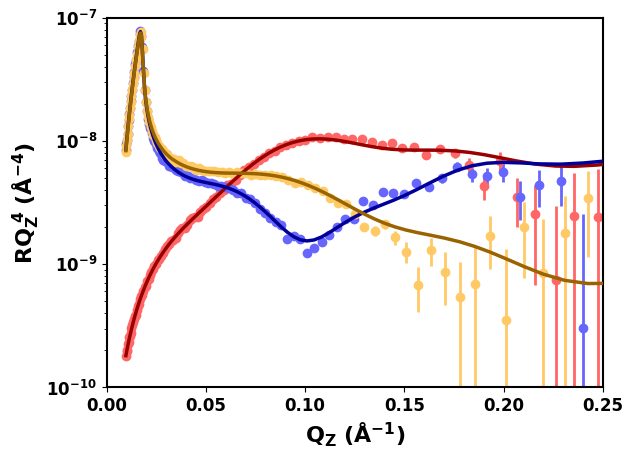

In [12]:
print(f"chi2: {global_objective.chisqr()/(global_objective.npoints - len(global_objective.varying_parameters()))}")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import colorsys


# Plot using refnx built-in function
fig, ax = global_objective.plot()

# Set axis line thickness
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# Font size and bold labels
ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')

# Axis formatting
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$")
)

# Axes scaling and limits
ax.set_yscale('log')
ax.set_xlabel(r'$\mathbf{Q}_\mathbf{Z}$ $\mathbf{(\AA}^{\mathbf{-1}}\mathbf{)}$', fontsize=16)
ax.set_ylabel(r'$\mathbf{RQ}_{\mathbf{Z}}^{\ \mathbf{4}}$ $\mathbf{(\AA}^{\mathbf{-4}}\mathbf{)}$', fontsize=16)
ax.set_xlim(0, 0.25)
ax.set_ylim(1E-10, 1E-7)

def adjust_color_lightness(color, factor):
    """Adjust lightness of a matplotlib color using HLS."""
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = np.clip(l * factor, 0, 1)
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b)

light_red = adjust_color_lightness('red', 1.4)    # lighter red
dark_red  = adjust_color_lightness('red', 0.6)    # darker red
light_blue = adjust_color_lightness('blue', 1.4)
dark_blue  = adjust_color_lightness('blue', 0.6)
light_orange = adjust_color_lightness('orange', 1.4)
dark_orange  = adjust_color_lightness('orange', 0.6)

# === Define custom colors for datasets === #
data_styles = {
    'dLip_acmw': {'color': light_red, 'line': dark_red},
    'dLip_d2o': {'color': light_blue, 'line': dark_blue},
    'hLip_d2o': {'color': light_orange, 'line': dark_orange},
}

# === Apply custom styles to data and fit lines === #
lines = ax.get_lines()
line_idx = 0

for objective in global_objective.objectives:
    label = objective.data.name
    if label not in data_styles:
        continue

    # --- Data line (markers) ---
    data_line = lines[line_idx]
    data_line.set_color(data_styles[label]['color'])
    data_line.set_marker('o')
    data_line.set_markersize(6)
    data_line.set_linestyle('None')
    data_line.set_label(label)  # For legend

    line_idx += 1

    # --- Fit line ---
    fit_line = lines[line_idx]
    fit_line.set_color(data_styles[label]['line'])
    fit_line.set_linewidth(2.5)
    fit_line.set_label(f"{label} fit")

    line_idx += 1

# === Fix error bar colors to match data points === #
# ax.collections are the error bars
for col, objective in zip(ax.collections, global_objective.objectives):
    label = objective.data.name
    if label in data_styles:
        col.set_color(data_styles[label]['color'])

# === Add legend === #
# ax.legend(frameon=True, prop={'weight': 'bold', 'size': 10})

# === Optional: Save figure for publication === #
fig.savefig("Ref_fit_SPB_45mNm.png", dpi=600, bbox_inches='tight')

#### Plot SLD profiles

C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_16228\3723533269.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_16228\3723533269.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')


<function matplotlib.pyplot.show(close=None, block=None)>

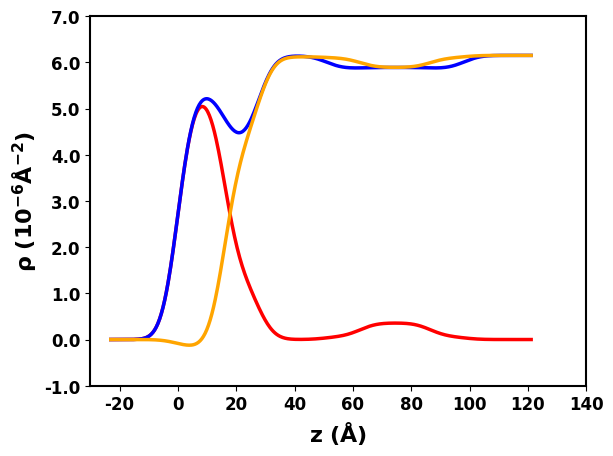

In [13]:
fig, ax = plt.subplots()

ax = plt.gca()  # Get the current axis

# Set the thickness of each axis line
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
import matplotlib.pyplot as plt

# Set the size of the x and y labels
ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')

# To round the values of x-axis to two decimal places
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

def adjust_color_lightness(color, factor):
    """Adjust lightness of a matplotlib color using HLS."""
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = np.clip(l * factor, 0, 1)
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b)

dark_red  = adjust_color_lightness('red', 0.6)    # darker red
dark_blue  = adjust_color_lightness('blue', 0.6)
dark_orange  = adjust_color_lightness('orange', 0.6)

ax.plot(*dLip_acmw.sld_profile(), label='dLip_acmw', color='red', linewidth=2.5)
ax.plot(*dLip_d2o.sld_profile(), label='dLip_d2o', color='blue', linewidth=2.5)
# ax.plot(*hLip_acmw.sld_profile(), label='hLip_acmw', color='green', linewidth=2.5)
ax.plot(*hLip_d2o.sld_profile(), label='hLip_d2o', color='orange', linewidth=2.5)

ax.set_ylabel(r"$\mathbf{\rho}$ $\mathbf{(10}^{\mathbf{-6}} \mathbf{\AA}^{\mathbf{-2}}\mathbf{)}$", fontsize=16)
ax.set_xlabel(r"$\mathbf{z}$ $\mathbf{(\AA)}$", fontsize=16)
plt.xlim(-30, 140)
plt.ylim(-1, 7)
# ax.legend(frameon=True, prop={'weight': 'bold', 'size': 10});
plt.show
# fig.savefig("SLD_profile_SPB_45mNm.png", dpi=600, bbox_inches='tight')

#### Generate and plot the volume fraction profiles
In this case, a volume fraction profile has been generated for each contrast, as the reservoir coverage varies between contrasts

C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_16228\3053595394.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_16228\3053595394.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')


(-0.1, 1.1)

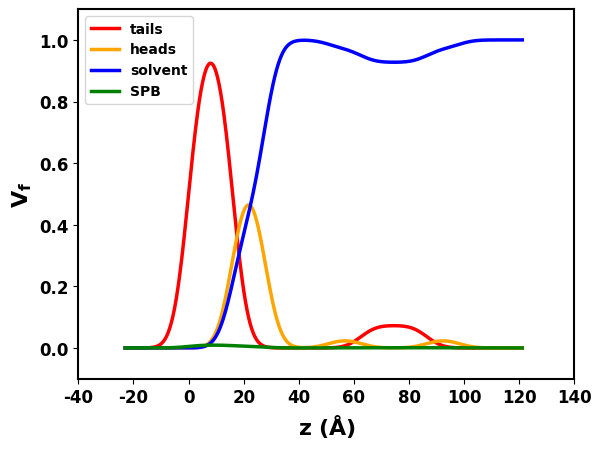

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Example of color choices
color_map = {
    "tails": "red",
    "heads": "orange",
    "SPB": "green",
    "solvent": "blue",
}

z, vfps = create_occupancy(dLip_acmw)

ax = plt.gca()  # Get the current axis

# Set the thickness of each axis line
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
import matplotlib.pyplot as plt

# Set the size of the x and y labels
ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')

# To round the values of x-axis to two decimal places
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# groups = [(1,5), (3), (2, 4, 6), (7,)]
# labels = ["tails", "solvent", "heads", "acmw"]
groups = [(1,5), (2, 4, 6), (3,7,)]
labels = ["tails", "heads", "solvent"]

for g, label in zip(groups, labels):
    vfp = np.take(
        vfps, g, axis=0
    )  # the take function is used to extract indices from a numpy array.
    if len(vfp.shape) > 1:
        vfp = np.sum(vfp, axis=0)
    plt.plot(z, vfp, label=label, linewidth=2.5, color=color_map[label])

# Plot SPB separately: 10% of layers 1 and 2, 100% of layer 3
vfp_spb = 0.009494 * vfps[1] + 0.009494 * vfps[2] + vfps[3] + 0.009494*vfps[4]  + 0.009494*vfps[5]  + 0.009494*vfps[6]
ax.plot(z, vfp_spb, label="SPB", linewidth=2.5, color=color_map["SPB"])
    

plt.legend(frameon=True, prop={'weight': 'bold', 'size': 10}, loc="upper left")
plt.ylabel(r'$\mathbf{V}_\mathbf{f}$', fontsize=16)
plt.xlabel(r"$\mathbf{z}$ $\mathbf{(\AA)}$", fontsize=16);
plt.xlim(-40, 140)
plt.ylim(-0.1, 1.1)

C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_16228\672388177.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_16228\672388177.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')


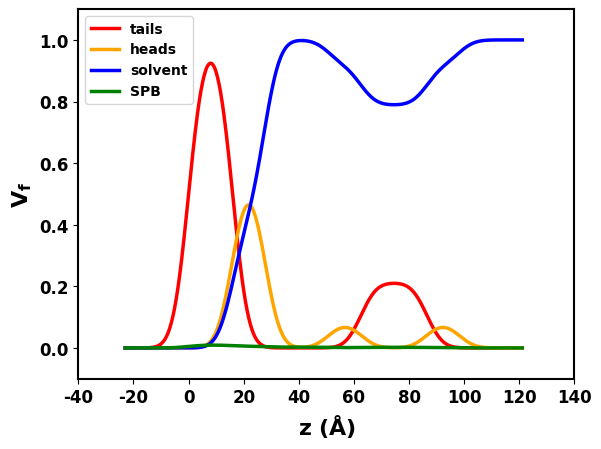

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Example of color choices
color_map = {
    "tails": "red",
    "heads": "orange",
    "SPB": "green",
    "solvent": "blue",
}

z, vfps = create_occupancy(dLip_d2o)

# Create plot
fig, ax = plt.subplots()

ax = plt.gca()  # Get the current axis

# Set the thickness of each axis line
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
import matplotlib.pyplot as plt

# Set the size of the x and y labels
ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')

# To round the values of x-axis to two decimal places
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# groups = [(1,5), (3), (2, 4, 6), (7,)]
# labels = ["tails", "solvent", "heads", "acmw"]
groups = [(1,5), (2, 4, 6), (3,7,)]
labels = ["tails", "heads", "solvent"]

for g, label in zip(groups, labels):
    vfp = np.take(
        vfps, g, axis=0
    )  # the take function is used to extract indices from a numpy array.
    if len(vfp.shape) > 1:
        vfp = np.sum(vfp, axis=0)
    plt.plot(z, vfp, label=label, linewidth=2.5, color=color_map[label])

# Plot SPB separately: 10% of layers 1 and 2, 100% of layer 3
vfp_spb = 0.009494 * vfps[1] + 0.009494 * vfps[2] + vfps[3] + 0.009494*vfps[4]  + 0.009494*vfps[5]  + 0.009494*vfps[6]
ax.plot(z, vfp_spb, label="SPB", linewidth=2.5, color=color_map["SPB"])
    

plt.legend(frameon=True, prop={'weight': 'bold', 'size': 10}, loc="upper left")
plt.ylabel(r'$\mathbf{V}_\mathbf{f}$', fontsize=16)
plt.xlabel(r"$\mathbf{z}$ $\mathbf{(\AA)}$", fontsize=16);
plt.xlim(-40, 140)
plt.ylim(-0.1, 1.1)

# plt.show

fig.savefig("Vfprofile_SPB_45mNm.png", dpi=600, bbox_inches='tight')

C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_16228\1481031226.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
C:\Users\carrascosa-tejedor\AppData\Local\Temp\ipykernel_16228\1481031226.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')


(-0.1, 1.1)

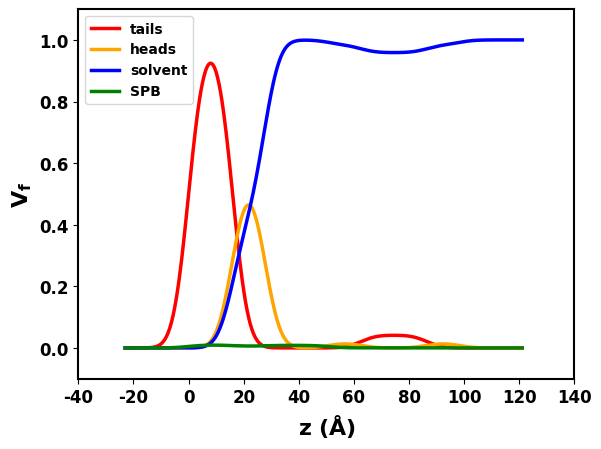

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Example of color choices
color_map = {
    "tails": "red",
    "heads": "orange",
    "SPB": "green",
    "solvent": "blue",
}

z, vfps = create_occupancy(hLip_d2o)

ax = plt.gca()  # Get the current axis

# Set the thickness of each axis line
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
import matplotlib.pyplot as plt

# Set the size of the x and y labels
ax.set_xticklabels(ax.get_xticks(), fontsize=12, fontweight='bold')
ax.set_yticklabels(ax.get_yticks(), fontsize=12, fontweight='bold')

# To round the values of x-axis to two decimal places
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# groups = [(1,5), (3), (2, 4, 6), (7,)]
# labels = ["tails", "solvent", "heads", "acmw"]
groups = [(1,5), (2, 4, 6), (3,7,)]
labels = ["tails", "heads", "solvent"]

for g, label in zip(groups, labels):
    vfp = np.take(
        vfps, g, axis=0
    )  # the take function is used to extract indices from a numpy array.
    if len(vfp.shape) > 1:
        vfp = np.sum(vfp, axis=0)
    plt.plot(z, vfp, label=label, linewidth=2.5, color=color_map[label])

# Plot SPB separately: 10% of layers 1 and 2, 100% of layer 3
vfp_spb = 0.009494 * vfps[1] + 0.009494 * vfps[2] + vfps[3] + 0.009494*vfps[4]  + 0.009494*vfps[5]  + 0.009494*vfps[6]
ax.plot(z, vfp_spb, label="SPB", linewidth=2.5, color=color_map["SPB"])
    

plt.legend(frameon=True, prop={'weight': 'bold', 'size': 10}, loc="upper left")
plt.ylabel(r'$\mathbf{V}_\mathbf{f}$', fontsize=16)
plt.xlabel(r"$\mathbf{z}$ $\mathbf{(\AA)}$", fontsize=16);
plt.xlim(-40, 140)
plt.ylim(-0.1, 1.1)

#### Perform MCMC analysis

In [17]:
fitter.reset()
fitter.sample(100, pool=1)
fitter.reset()

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


In [18]:
res = fitter.sample(100, nthin=10, pool=1)

100%|██████████| 1000/1000 [18:32<00:00,  1.11s/it]


#### Print chi2 and a summary of the fitted paremeters

In [19]:
print(f"chi2: {global_objective.chisqr()/(global_objective.npoints - len(global_objective.varying_parameters()))}")
print(global_objective.parameters.varying_parameters())

chi2: 4.283622655354556
________________________________________________________________________________
Parameters:      None      
<Parameter: 'tail_thick'  , value=15.976 +/- 0.0447, bounds=[10.0, 30.0]>
<Parameter:  'dtail_SLD'  , value=5.3967 +/- 0.0136, bounds=[4.917084590931521, 7.375626886397282]>
<Parameter: 'head_thick'  , value=11.5567 +/- 0.145, bounds=[8.0, 15.0]>
<Parameter:  'gap_thick'  , value=23.8186 +/- 0.43 , bounds=[10.0, 50.0]>
<Parameter:'gap_vfsolv_dlip_acmw', value=0.999075 +/- 0.00108, bounds=[0.0, 1.0]>
<Parameter:'headreservoir_vfsolv', value=0.971598 +/- 0.000579, bounds=[0.5, 0.99]>
<Parameter:'tailreservoir_thick', value=23.3689 +/- 0.684, bounds=[20.0, 40.0]>
<Parameter:'gap_vfsolv_dlip_d2o', value=0.996231 +/- 0.00229, bounds=[0.0, 1.0]>
<Parameter:'headreservoir_vfsolv_dlip_d2o', value=0.917704 +/- 0.00221, bounds=[0.5, 0.99]>
<Parameter:'gap_vfsolv_hlip_d2o', value=0.991072 +/- 0.00219, bounds=[0.0, 1.0]>
<Parameter:'headreservoir_vfsolv_dlip_d2o', va

##### Print summary of the most relevant parameters

In [20]:
print(f"chi2: {global_objective.chisqr()/(global_objective.npoints - len(global_objective.varying_parameters()))}")
print("MONOLAYER")
print(tail_thick)
print(p_tails_vf)
print(dtail_SLD)
print(htail_SLD)
print(f"Delta %SLD: {100*(dtail_SLD.value-4.92)/4.92}")
print()
print(head_thick)
print(head_vfsolv)
print(p_heads_vf)
print(rough_monolayer)
print()
print(f"Gamma_tails_monolayer: {Gamma_tails_monolayer.value}")
print(f"Gamma_heads_monolayer: {Gamma_heads_monolayer.value}")
print(f"A_permolecule_tails_monolayer: {A_permolecule_tails_monolayer.value}")
print(f"A_permolecule_heads_monolayer: {A_permolecule_heads_monolayer.value}")
print()
print("GAP LAYER")
print(gap_thick)
print(gap_vfsolv_dlip_acmw)
print(gap_vfsolv_dlip_d2o)
print(gap_vfsolv_hlip_d2o)
print()
print("RESERVOIR LAYER")
print(head_thick)
print(headreservoir_vfsolv_dlip_acmw)
print(headreservoir_vfsolv_dlip_d2o)
print(headreservoir_vfsolv_hlip_d2o)
print(tailreservoir_thick)
print(tailreservoir_vfsolv_dlip_acmw)
print(tailreservoir_vfsolv_dlip_d2o)
print(tailreservoir_vfsolv_hlip_d2o)
print(rough_reservoir)
print(Gamma_heads_reservoir_dlip_acmw)
print(Gamma_tails_reservoir_dlip_acmw)
print(Gamma_heads_reservoir_dlip_d2o)
print(Gamma_tails_reservoir_dlip_d2o)
print(Gamma_heads_reservoir_hlip_d2o)
print(Gamma_tails_reservoir_hlip_d2o)
print()


chi2: 4.283622655354556
MONOLAYER
<Parameter: 'tail_thick'  , value=15.976 +/- 0.0447, bounds=[10.0, 30.0]>
<Parameter:'p_tails_vfsolv', value=0.009494  (fixed) , bounds=[0.0, 1.0]>
<Parameter:  'dtail_SLD'  , value=5.3967 +/- 0.0136, bounds=[4.917084590931521, 7.375626886397282]>
<Parameter:  'htail_SLD'  , value=-0.1713 +/- 0.000431, bounds=[-0.2341140961933507, -0.15607606412890046], constraint=<Parameter:     None      , value=-0.1713  (fixed) , bounds=None>>
Delta %SLD: 9.689078590120452

<Parameter: 'head_thick'  , value=11.5567 +/- 0.145, bounds=[8.0, 15.0]>
<Parameter: 'head_vfsolv' , value=0.419704 +/- 0.00699, bounds=[0.0, 0.7], constraint=<Parameter:     None      , value=0.419704  (fixed) , bounds=None>>
<Parameter:'p_head_vfsolv', value=0.009494  (fixed) , bounds=[0.0, 1.0]>
<Parameter:'rough_monolayer', value=4.5  (fixed) , bounds=[4.0, 8.0]>

Gamma_tails_monolayer: 3.3092627857363786
Gamma_heads_monolayer: 3.309262785736379
A_permolecule_tails_monolayer: 50.1796922341757

#### Vertification of applied constraints

In [21]:
# Verify that the constraints are correctly applied across all contrasts

# (1) Constraint [Gamma_tails_monolayer = Gamma_heads_monolayer]
print(f"Gamma_heads_monolayer_d_acmw: {(head_thick*d_head_acmw_SLD*(1 - p_heads_vf - head_vfsolv))/(d_head_acmw_SL*0.06023)}")
print(f"Gamma_tails_monolayer_d_acmw: {(tail_thick*dtail_SLD*(1 - p_tails_vf))/(dtail_SL*0.06023)}")
print()
print(f"Gamma_heads_monolayer_d_d2o: {(head_thick*d_head_d2o_SLD*(1 - p_heads_vf - head_vfsolv))/(d_head_d2o_SL*0.06023)}")
print(f"Gamma_tails_monolayer_d_d2o: {(tail_thick*dtail_SLD*(1 - p_tails_vf))/(dtail_SL*0.06023)}")
print()
# print(f"Gamma_heads_monolayer_h_acmw: {(head_thick*h_head_acmw_SLD*(1 - p_heads_vf - head_vfsolv))/(h_head_acmw_SL*0.06023)}")
# print(f"Gamma_tails_monolayer_h_acmw: {(tail_thick*htail_SLD*(1 - p_tails_vf))/(htail_SL*0.06023)}")
# print()
print(f"Gamma_heads_monolayer_h_d2o: {(head_thick*h_head_d2o_SLD*(1 - p_heads_vf - head_vfsolv))/(h_head_d2o_SL*0.06023)}")
print(f"Gamma_tails_monolayer_h_d2o: {(tail_thick*htail_SLD*(1 - p_tails_vf))/(htail_SL*0.06023)}")
print()

# (2) Constraint [Gamma_tails_reservoirs = 2 * Gamma_heads_reservoirs]
print(f"Gamma_heads_reserovir_d_acmw: {(head_thick*d_head_acmw_SLD*(1-headreservoir_vfsolv_dlip_acmw))/(d_head_acmw_SL*0.06023)}")
print(f"Gamma_tails_reserovir_d_acmw: {(tailreservoir_thick*dtail_SLD_reservoir*(1-tailreservoir_vfsolv_dlip_acmw))/(dtail_SL*0.06023)}")
print()
print(f"Gamma_heads_reserovir_d_d2o: {(head_thick*d_head_d2o_SLD*(1-headreservoir_vfsolv_dlip_d2o))/(d_head_d2o_SL*0.06023)}")
print(f"Gamma_tails_reserovir_d_d2o: {(tailreservoir_thick*dtail_SLD_reservoir*(1-tailreservoir_vfsolv_dlip_d2o))/(dtail_SL*0.06023)}")
# print()
# print(f"Gamma_heads_reserovir_h_acmw: {(head_thick*h_head_acmw_SLD*(1-headreservoir_vfsolv))/(h_head_acmw_SL*0.06023)}")
# print(f"Gamma_tails_reserovir_h_acmw: {(tailreservoir_thick*htail_SLD_reservoir*(1-tailreservoir_vfsolv))/(htail_SL*0.06023)}")
print()
print(f"Gamma_heads_reserovir_h_d2o: {(head_thick*h_head_d2o_SLD*(1-headreservoir_vfsolv_hlip_d2o))/(h_head_d2o_SL*0.06023)}")
print(f"Gamma_tails_reserovir_h_d2o: {(tailreservoir_thick*htail_SLD_reservoir*(1-tailreservoir_vfsolv_hlip_d2o))/(htail_SL*0.06023)}")
print()
# (3) The constraint between dtail_SLD and htail_SLD must be verified by calculating the molecular volume of the tail for both, ensuring that they yield the same value
print(f"Vm_dtail: {(10*dtail_SL/dtail_SLD)}")
print(f"Vm_htail: {(10*htail_SL/htail_SLD)}")

Gamma_heads_monolayer_d_acmw: <Parameter:     None      , value=3.30926  (fixed) , bounds=None>
Gamma_tails_monolayer_d_acmw: <Parameter:     None      , value=3.30926  (fixed) , bounds=None>

Gamma_heads_monolayer_d_d2o: <Parameter:     None      , value=3.30926  (fixed) , bounds=None>
Gamma_tails_monolayer_d_d2o: <Parameter:     None      , value=3.30926  (fixed) , bounds=None>

Gamma_heads_monolayer_h_d2o: <Parameter:     None      , value=3.30926  (fixed) , bounds=None>
Gamma_tails_monolayer_h_d2o: <Parameter:     None      , value=3.30926  (fixed) , bounds=None>

Gamma_heads_reserovir_d_acmw: <Parameter:     None      , value=0.164665  (fixed) , bounds=None>
Gamma_tails_reserovir_d_acmw: <Parameter:     None      , value=0.329331  (fixed) , bounds=None>

Gamma_heads_reserovir_d_d2o: <Parameter:     None      , value=0.477117  (fixed) , bounds=None>
Gamma_tails_reserovir_d_d2o: <Parameter:     None      , value=0.954234  (fixed) , bounds=None>

Gamma_heads_reserovir_h_d2o: <Paramet

#### List of parameters of the Global Objective

In [22]:
print(global_objective)

________________________________________________________________________________


--Global Objective--
________________________________________________________________________________
Objective - dLip_acmw
Dataset = dLip_acmw
datapoints = 97
chi2 = 239.32828523678174
Weighted = True
Transform = Transform('YX4')
________________________________________________________________________________
Parameters: 'model_dLip_acmw'
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:    'scale'    , value=1  (fixed) , bounds=[-inf, inf]>
<Parameter:     'bkg'     , value=1e-06  (fixed) , bounds=[-inf, inf]>
<Parameter:'dq - resolution', value=7  (fixed) , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
___________________________________________________________________________